#Deep Embedding Clustering (DEC)

Src: https://github.com/XifengGuo/DEC-keras/tree/2438070110b17b4fb9bc408c11d776fc1bd1bd56 

This is from the Keras implementation for ICML-2016 paper: Unsupervised deep embedding for clustering analysis. ICML 2016.
Authors: Junyuan Xie, Ross Girshick, and Ali Farhadi. 

##**1. Model Creation**

THe autoencoder model is created using 4 dense layers. After that the output of these dense payers are provided to a clustering layer. To train the network the model used the KL divergence loss and Stochastic Gradient Descent (SGD). 

In [1]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:
        Junyuan Xie, Ross Girshick, and Ali Farhadi. Unsupervised deep embedding for clustering analysis. ICML 2016.
Usage:
    use `python DEC.py -h` for help.
Author:
    Xifeng Guo. 2017.1.30
"""

from time import time
import numpy as np
import keras.backend as K
#from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import metrics


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')


class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20, n_jobs=4)
                    y_pred = km.fit_predict(features)
                    # print()
                    #print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|' % (metrics.acc(self.y, y_pred), metrics.nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: %ds' % round(time() - t0))
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        #save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        save_interval = 500
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                print("#### inside iteration ### ", ite)
                if y is not None:
                    #acc = np.round(metrics.acc(y, y_pred), 5)
                    #nmi = np.round(metrics.nmi(y, y_pred), 5)
                    #ari = np.round(metrics.ari(y, y_pred), 5)
                    loss = np.round(loss, 5)
                    logdict = dict(iter=ite, loss=loss)  #logdict = dict(iter=ite, acc=acc, nmi=nmi, ari=ari, loss=loss)
                    logwriter.writerow(logdict)
                    print('Iter %d: ' % (iter), ' ; loss=', loss)  #print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print("##### Prediction in side the iter and the delta_label is ", delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 0 and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            print("#### the loss is ", loss)
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [2]:
import netCDF4
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import datetime as dt
from netCDF4 import date2num,num2date
from math import sqrt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rdata_daily = xr.open_dataset('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc').rename({'latitude':'lat','longitude':'lon'})
#rdata_daily = rioxarray.open_rasterio('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc').rename({'y':'lon','x':'lat'})
rdata_daily

<xarray.Dataset>
Dimensions:  (time: 365, lon: 41, lat: 41)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
  * lon      (lon) float32 -33.0 -32.75 -32.5 -32.25 ... -23.5 -23.25 -23.0
  * lat      (lat) float32 43.0 42.75 42.5 42.25 42.0 ... 33.75 33.5 33.25 33.0
Data variables:
    sp       (time, lat, lon) float64 ...
    sst      (time, lat, lon) float64 ...
    u10      (time, lat, lon) float64 ...
    v10      (time, lat, lon) float64 ...
    sshf     (time, lat, lon) float64 ...
    slhf     (time, lat, lon) float64 ...
    t2m      (time, lat, lon) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

# **2.Data preparation**
The model takes one row for each data point/day. But our dataset size is 265x7x41x41. So I have transformed the data of one day from 7x41x41 to one row with 11767 data. Our daily data have some NaN values in the SST variable. To replace these NaN values I have used the mean value of the longitude and latitude of that day. If we take the mean from all of the days it will misrepresent that data point. The function  The function returns 1 NumPy arrays one with size (365, 11767). 

In [4]:
## This function will will pre-process our daily data for DEC model as numpy array
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def data_preprocessing(data_path):
  rdata_daily = xr.open_dataset(data_path)    # data_path = '/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc'
  rdata_daily_np_array = np.array(rdata_daily.to_array())   # the shape of the dailt data is (7, 365, 41, 41)
  rdata_daily_np_array_T = rdata_daily_np_array.transpose(1,0,2,3)   # transform the dailt data from (7, 365, 41, 41) to (365, 7, 41, 41)
  for i in range(rdata_daily_np_array_T.shape[0]):
    for j in range(rdata_daily_np_array_T.shape[1]):
      for k in range(rdata_daily_np_array_T.shape[2]):
        for l in range(rdata_daily_np_array_T.shape[3]):
          if np.isnan(rdata_daily_np_array_T[i, j, k, l]):
            #print("NAN data in ", i, j, k, l)
            rdata_daily_np_array_T[i, j, k, l]=np.nanmean(rdata_daily_np_array_T[i, j, k, :])
  rdata_daily_np_array_T_R = rdata_daily_np_array_T.reshape((rdata_daily_np_array_T.shape[0], -1))  # transform the dailt data from (365, 7, 41, 41) to (365, 11767)
  min_max_scaler = preprocessing.MinMaxScaler() # calling the function
  rdata_daily_np_array_T_R_nor = min_max_scaler.fit_transform(rdata_daily_np_array_T_R)   # now normalize the data, otherwise the loss will be very big 
  rdata_daily_np_array_T_R_nor = np.float32(rdata_daily_np_array_T_R_nor)    # convert the data type to float32, otherwise the loass will be out-of-limit 
  return rdata_daily_np_array_T_R_nor


In [5]:
from sklearn.metrics import silhouette_samples, silhouette_score
def silhouette_score1(X, labels, *, metric="cosine", sample_size=None, random_state=None, **kwds):  
 return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))

## **3. Model Training**
This function defines related parameters to train the model. Then instantiate the model and train on the pre-processed data. The model tries to optimize the clustering loss. After training the model returns the cluster results. 

In [6]:
def main():
    # setting the hyper parameters

    batch_size = 256
    maxiter = 2e4
    pretrain_epochs = 3
    update_interval = 30
    tol = 0.00001
    ae_weights = None
    save_dir = '/content/drive/MyDrive/DEC_result'

    # load dataset
    data_path = '/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc'
    x = data_preprocessing(data_path)
    y = None
    n_clusters = 7

    init = 'glorot_uniform'
    #init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
    #pretrain_optimizer = 'adam'
    pretrain_optimizer = SGD(learning_rate=0.1, momentum=0.9)
    # setting parameters

    # prepare the DEC model
    dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 50], n_clusters=n_clusters, init=init)

    if ae_weights is None:
        dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                     epochs=pretrain_epochs, batch_size=batch_size,
                     save_dir=save_dir)
    else:
        dec.autoencoder.load_weights(ae_weights)

    dec.model.summary()
    t0 = time()
    dec.compile(optimizer=SGD(0.00001, 0.9), loss='kld')
    y_pred = dec.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    #print('acc:', metrics.acc(y, y_pred))
    print('clustering time: ', (time() - t0))
    return y_pred

In [23]:
res = main()
res

...Pretraining...
Epoch 1/3
2/2 [==============================] - 1s 248ms/step - loss: 0.4011
Epoch 2/3
2/2 [==============================] - 1s 266ms/step - loss: 0.4010
Epoch 3/3
2/2 [==============================] - 1s 224ms/step - loss: 0.4009
Pretraining time: 3s
Pretrained weights are saved to /content/drive/MyDrive/DEC_result/ae_weights.h5
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 11767)]           0         
                                                                 
 encoder_0 (Dense)           (None, 500)               5884000   
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                    

array([0, 0, 2, 2, 2, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 4, 4, 4, 4, 0, 4, 4, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 4, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 2,
       4, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 4, 4, 4, 0, 4, 4, 4, 0, 0, 2, 0, 0, 0, 0, 2, 4, 4, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 5,
       5, 5, 3, 5, 5, 5, 6, 3, 3, 6, 6, 3, 3, 6, 6, 6, 6, 3, 3, 3, 6, 6,
       6, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 3, 3,
       3, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6, 6, 6, 3, 3, 6, 6, 3, 3, 3,
       3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3,
       3, 3, 3, 5, 5, 6, 3, 3, 3, 6, 6, 3, 3, 6, 6,

In [15]:
u,indices = np.unique(res,return_counts = True)
u,indices

(array([0, 1, 2, 3, 4, 5, 6]), array([ 32, 146,  37,  47,  22,  17,  64]))

In [24]:
data_path = '/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc'
nor_data = data_preprocessing(data_path)
silhouette_avg_rdata_daily = silhouette_score1(nor_data, res)
print("The average silhouette_score is :", silhouette_avg_rdata_daily)

The average silhouette_score is : 0.18661027


In [25]:
res         

array([0, 0, 2, 2, 2, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0,
       0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 4, 4, 4, 4, 0, 4, 4, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 2, 4, 4, 2, 2, 4, 4, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 0, 0, 2,
       4, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 4, 4, 4, 0, 4, 4, 4, 0, 0, 2, 0, 0, 0, 0, 2, 4, 4, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 5, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 5,
       5, 5, 3, 5, 5, 5, 6, 3, 3, 6, 6, 3, 3, 6, 6, 6, 6, 3, 3, 3, 6, 6,
       6, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 3, 3,
       3, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6, 6, 6, 3, 3, 6, 6, 3, 3, 3,
       3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3,
       3, 3, 3, 5, 5, 6, 3, 3, 3, 6, 6, 3, 3, 6, 6,

## **4. Visualization:**
To visualize clustering results I have downloaded the python file from GitHub and loaded in the current runtime using file operation. As our current GitHub repository is private, so we can't import this directly from the GitHub. 
Execute the follow ing cells to visualize the generated clusters. 

In [13]:
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
path = '/content/drive/MyDrive/visualization.py'
path_1 = '/content/drive/MyDrive/coast.txt'

with open(path, "r") as file1:
    FileContent = file1.read()
    with open('visualization.py', 'w') as f:
      f.write(FileContent)
    #print(FileContent)

with open(path_1, "r") as file1:
    FileContent = file1.read()
    with open('coast.txt', 'w') as f:
      f.write(FileContent)
# now we can import
#import visualization as vis
#import visualization as vis

In [18]:
import visualization as vis

In [26]:
df=pd.DataFrame()
df1=pd.DataFrame()
df['time_step'] = np.arange(len(res))
df['clusterid'] = pd.DataFrame(res)
df.to_csv('/content/drive/MyDrive/dec-result-1.csv',index=True)

total clusters:  7
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


/content/visualization.py:128: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/content/visualization.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(panel)
/content/visualization.py:71: UserWarning: The following kwargs were not used by contour: 'linewidth'
  p1=ax.contour(lon0,lat0,var,cmap=cmap0,levels=np.arange(var_range[0],var_range[1],(var_range[1]-var_range[0])/11),extend = 'both',linewidth=0.6)


varid: t2m
var_range: [-0.08280723076385484, -0.07839707801928061]
varid: u10
var_range: [-15.129702662479593, 16.82725476413482]
varid: v10
var_range: [-14.294945017569995, 14.039669939743764]
varid: sshf
var_range: [-43.41541985801895, 175.22246693947238]
varid: sp
var_range: [985.3787786916515, 1035.1150602330122]


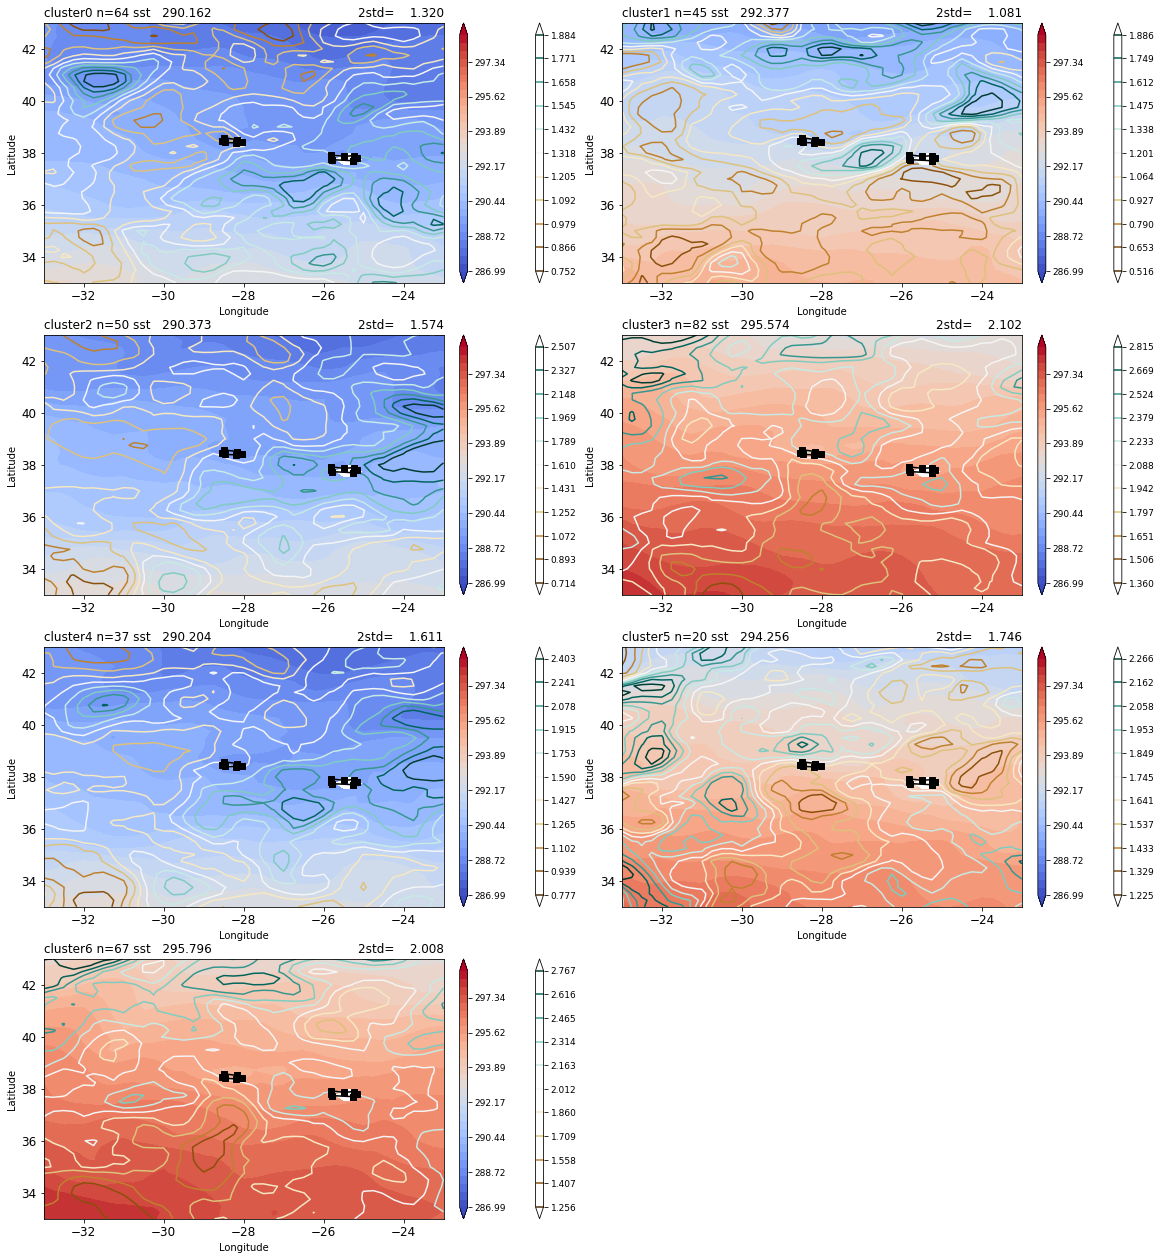

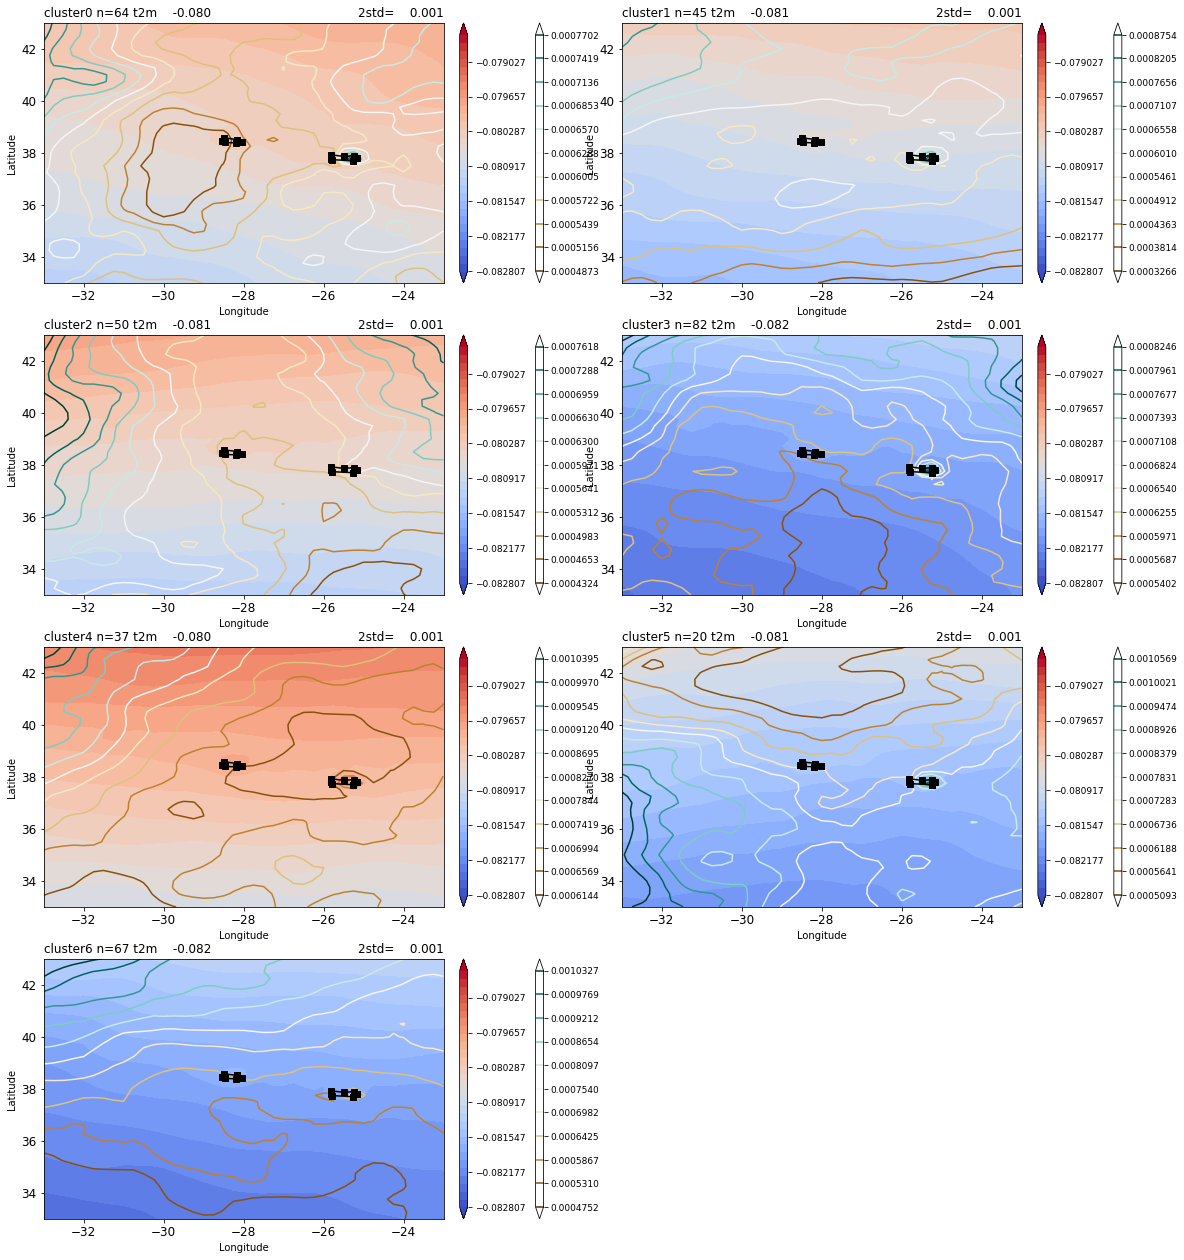

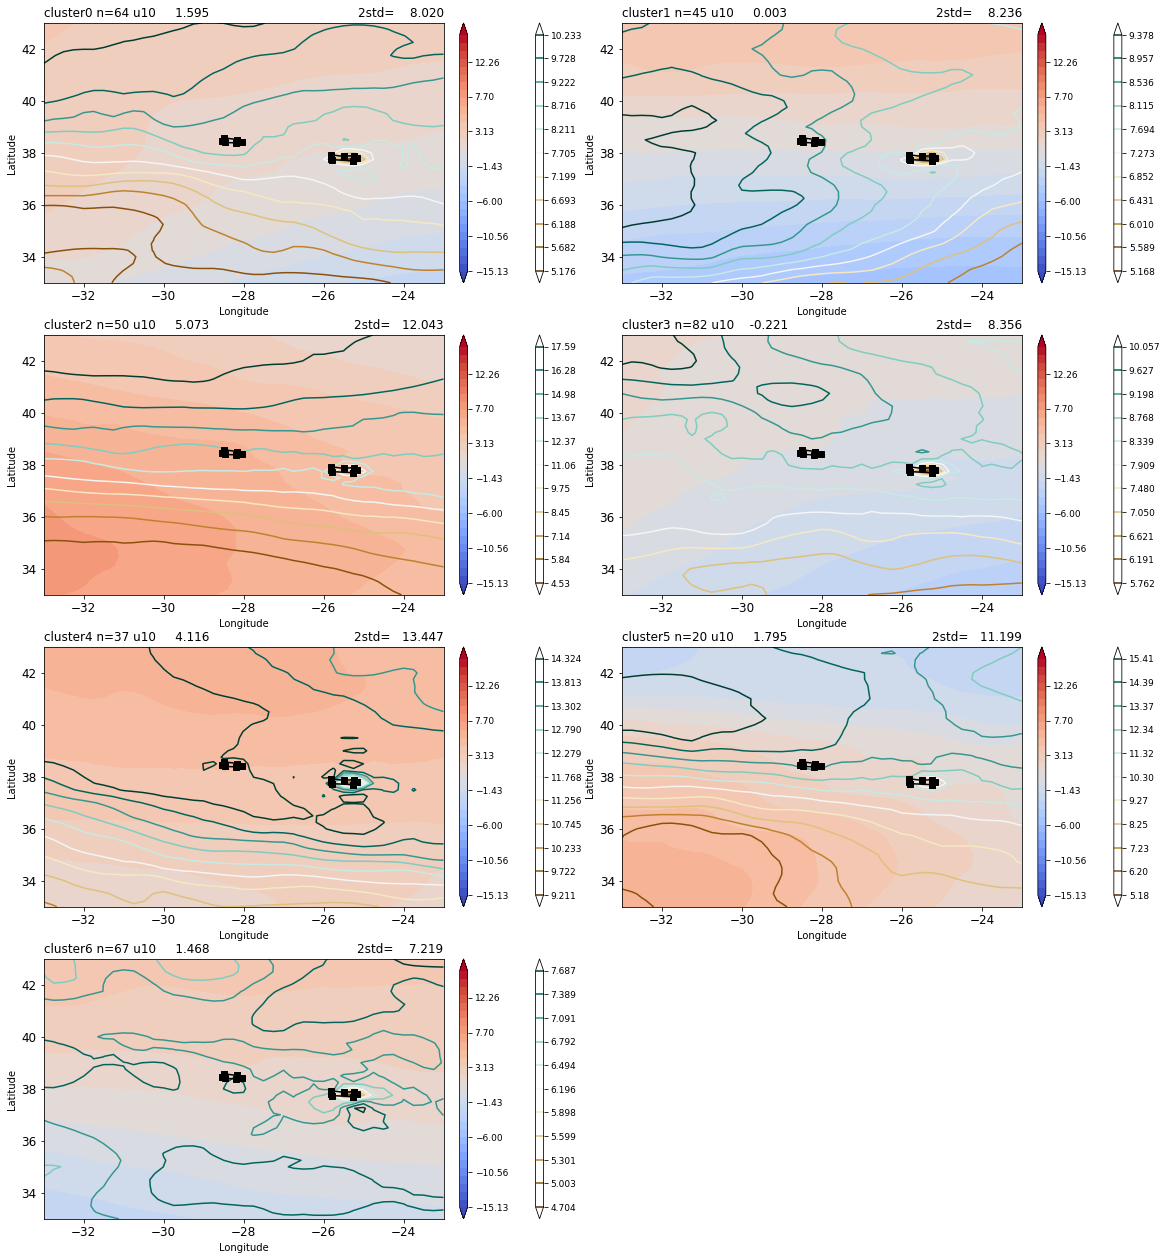

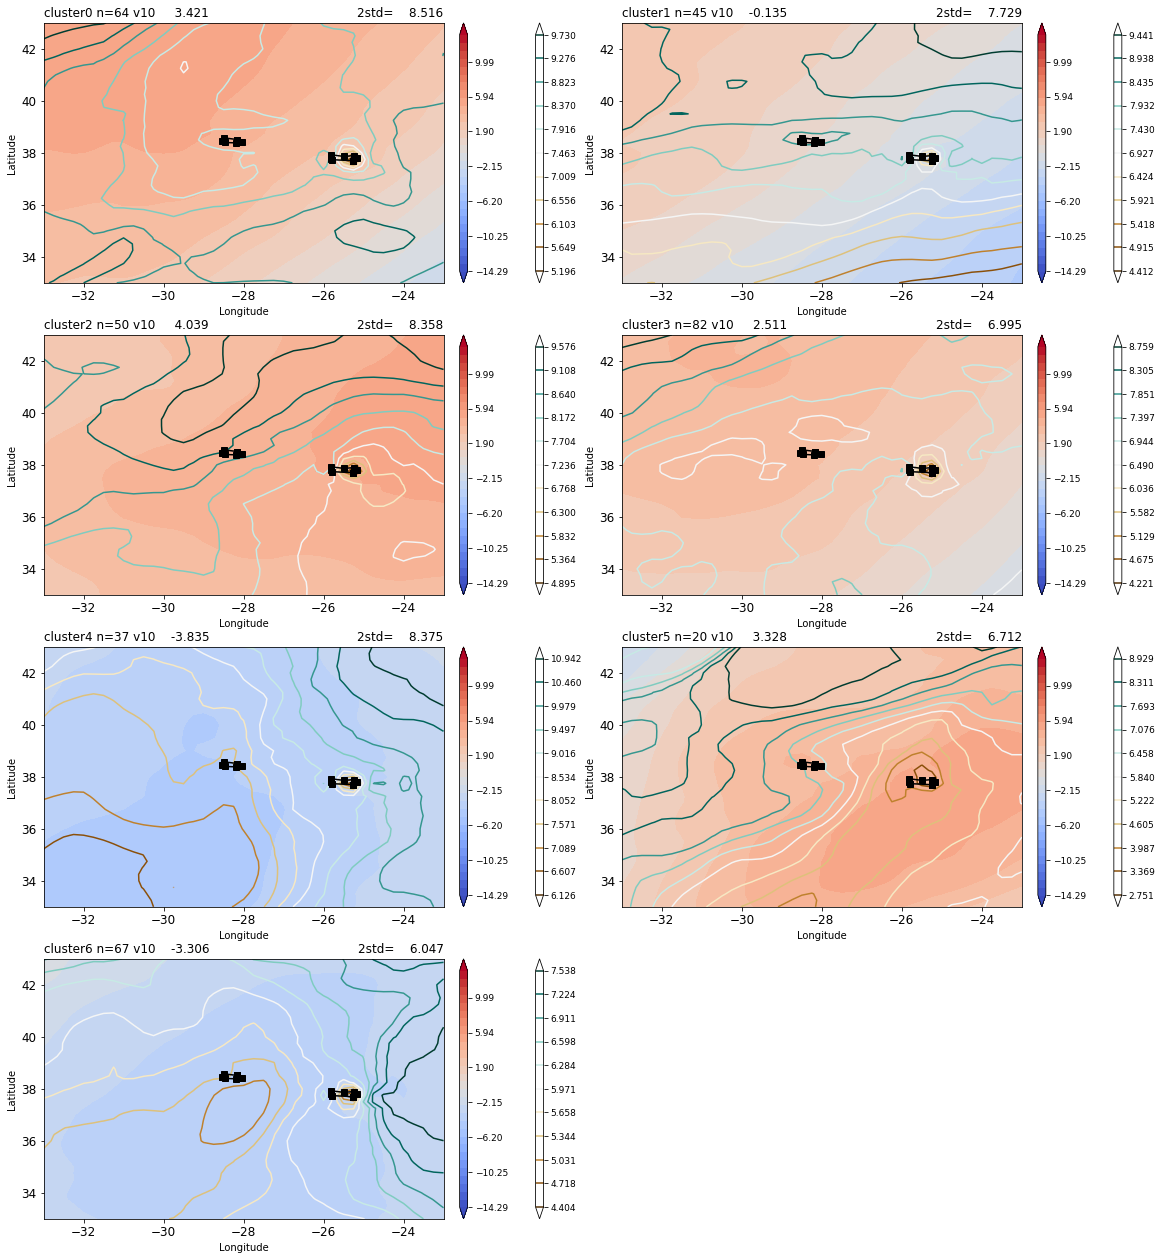

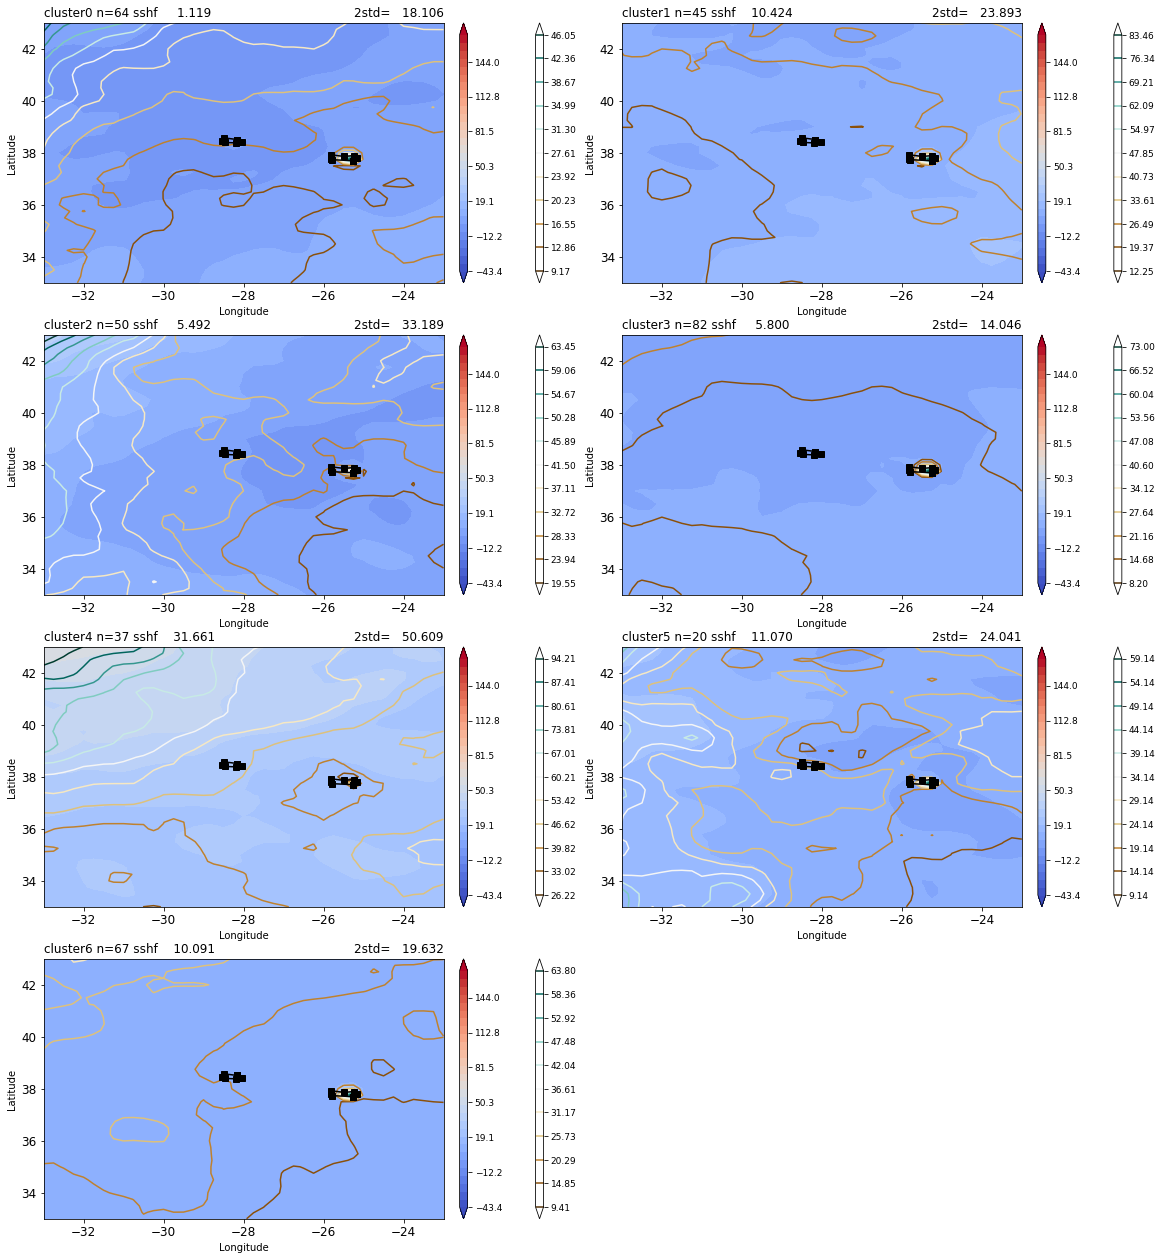

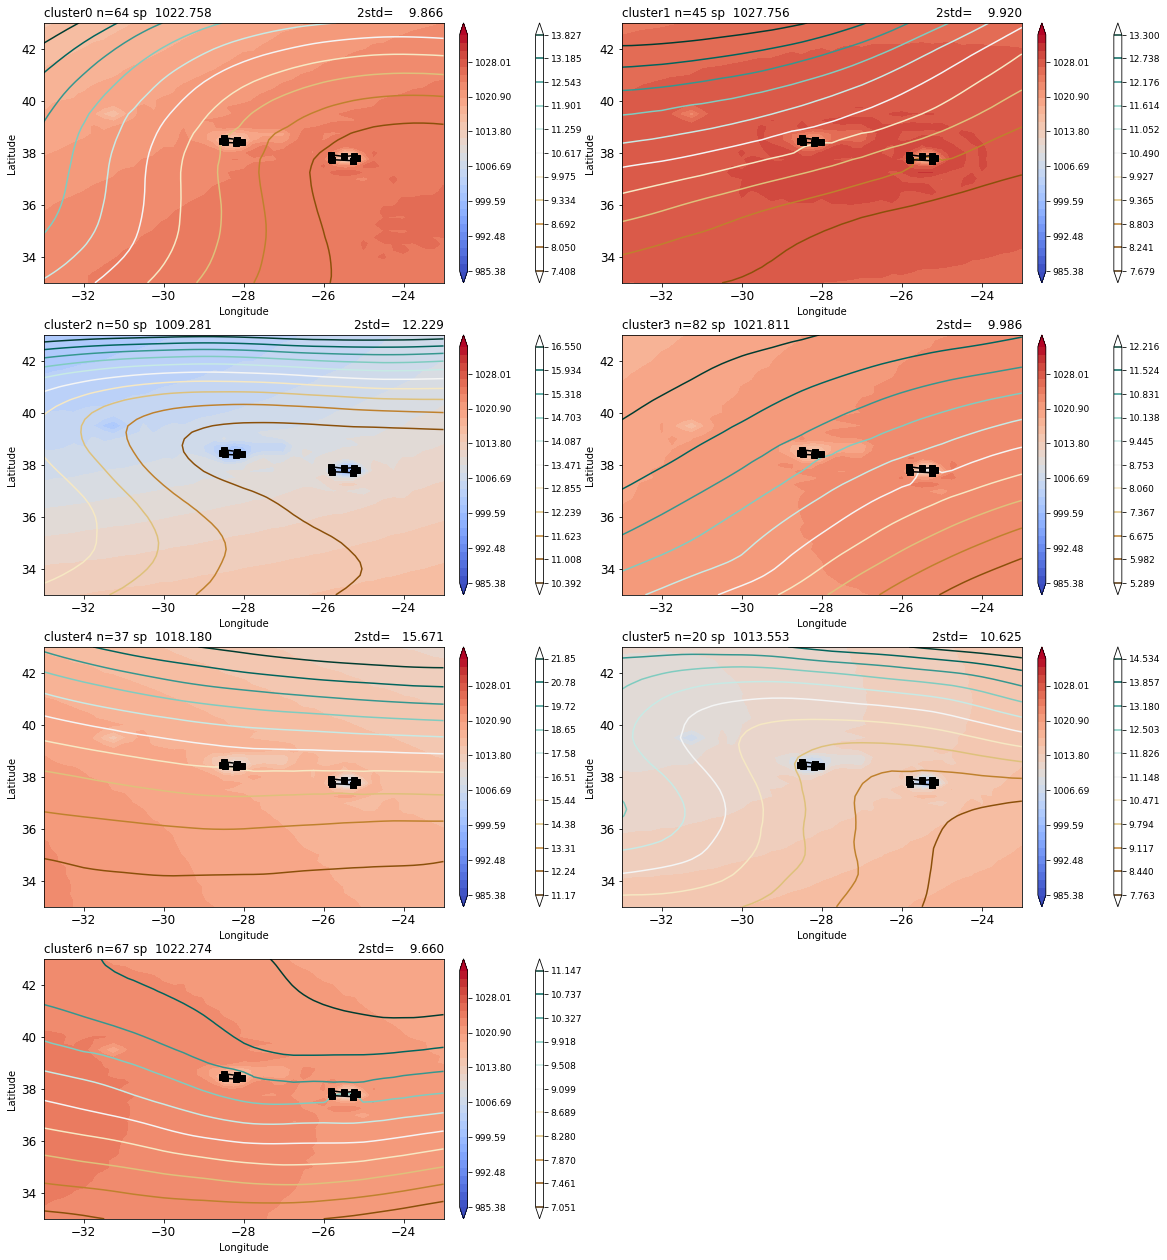

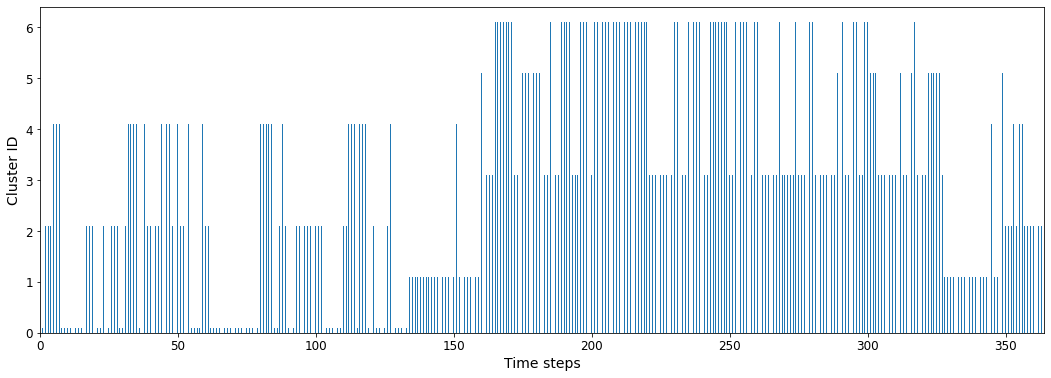

In [27]:
vis.visualization('/content/drive/MyDrive/ERA5_meteo_sfc_2021_daily.nc' ,'/content/drive/MyDrive/dec-result-1.csv', './coast.txt')